# Consider the ODE <br>
$dy/dx = -2xy$ <br> 
with initial condition <br>
$y(0)=1$ <br>
and analytical solution <br>
$y(x)=e^{-x^2}$

following matlab example https://www.mathworks.com/help/deeplearning/ug/solve-odes-using-a-neural-network.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def MSE(y_pred, y_true=None):
    """
    computes MSE error
    """
    if y_true is None:
        return tf.reduce_mean(y_pred ** 2)
    else:
        return tf.reduce_mean((y_pred - y_true) ** 2)

In [3]:
# take n number of samples
n_samples = 10000

# sample x from 0 to 2
x = np.linspace(0,2,n_samples).reshape(n_samples,1)

# initial condition of x is when x=0
x0 = np.zeros(n_samples,).reshape(n_samples,1)

# initial conditoin of y(0)=1
y0 = np.ones(n_samples).reshape(n_samples,1)

# move these numpy arrays to tensors
x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
x0_tensor = tf.convert_to_tensor(x0, dtype=tf.float32)
y0_tensor = tf.convert_to_tensor(y0, dtype=tf.float32)


train_dataset = tf.data.Dataset.from_tensor_slices((x_tensor, x0_tensor, y0_tensor))

batch_size = 1000
train_dataset_shuffled = train_dataset.shuffle(10000).batch(batch_size)

In [4]:
# define model -> input x and predict y with one hidden layer

# accept 1 input 
inputs = tf.keras.Input((1,))

# two hidden layer with 20 neurons, activation function of sigmoid and no bias 
L1 = tf.keras.layers.Dense(30, activation='sigmoid', use_bias=True)(inputs)

# output layer predicts y with activation function of sigmoid to constrain output between 0 and 1
outputs = tf.keras.layers.Dense(1)(L1)

# build model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
num_epochs = 1000

In [5]:
# define loss function 
def loss_ode(model, x_tensor, x0_tensor, y0_tensor):
  x_copy = tf.identity(x_tensor)                       # make copy of x for gradients
  with tf.GradientTape() as t:
    t.watch(x_copy)                                    # watch x variable for auto diff
    y_pred = model(x_copy)                             # make model prediction for y
  dy_dx = t.gradient(y_pred,x_copy)                    # take derivative dy/dx
  res = dy_dx + 2*y_pred*x_copy                        # define resisual from the ode 
  res_loss = sum([MSE(res_i) for res_i in res])        # calculate MSE loss for residual

  ic_loss = sum([MSE(model(x0_tensor),y0_tensor)])     # calculate initial condition loss comparing the model
                                                       # evaluated at 0 to the expected result of 1

  ic_coeff = 5                                         # initial condition coefficient taken from matlab example
  
  loss_full = res_loss + ic_coeff*ic_loss              # calcuate total loss

  return loss_full, res_loss, ic_loss                  # return all the lossses

In [6]:
best_loss = np.inf
training_loss = []
ode_loss = []
ic_loss_list = []
for epoch in range(num_epochs):
  for x_batch, x0_batch, y0_batch in train_dataset_shuffled:
    with tf.GradientTape() as t1:
      loss_full, res_loss, ic_loss = loss_ode(model, x_batch, x0_batch, y0_batch)  # calculate losses
      training_loss.append(loss_full.numpy())
      ode_loss.append(res_loss.numpy())
      ic_loss_list.append(ic_loss.numpy())
    grad = t1.gradient(loss_full, model.trainable_variables)            # calculate gradients based off full loss
    optimizer.apply_gradients(zip(grad, model.trainable_variables))     # apply gradients to optimizer
    
  if loss_full.numpy() < best_loss:
    best_loss = loss_full.numpy()
    model.save_weights('best_model')
  
  if epoch % 1 == 0:
    #print(f'epoch: {epoch}, loss: {loss_full.numpy()}, res_loss: {res_loss.numpy()}, ic_loss:{ic_loss.numpy()}') 
    print(f'epoch: {epoch}, Best Loss = {best_loss}') 



epoch: 0, Best Loss = 22.67992401123047
epoch: 1, Best Loss = 22.67992401123047
epoch: 2, Best Loss = 22.67992401123047
epoch: 3, Best Loss = 21.56422233581543
epoch: 4, Best Loss = 14.996681213378906
epoch: 5, Best Loss = 13.91118049621582
epoch: 6, Best Loss = 11.779365539550781
epoch: 7, Best Loss = 10.940547943115234
epoch: 8, Best Loss = 9.190561294555664
epoch: 9, Best Loss = 8.975481986999512
epoch: 10, Best Loss = 7.909783363342285
epoch: 11, Best Loss = 7.246533393859863
epoch: 12, Best Loss = 6.760617256164551
epoch: 13, Best Loss = 6.170521259307861
epoch: 14, Best Loss = 5.807347774505615
epoch: 15, Best Loss = 5.606633186340332
epoch: 16, Best Loss = 5.416720867156982
epoch: 17, Best Loss = 5.219606399536133
epoch: 18, Best Loss = 5.149991989135742
epoch: 19, Best Loss = 5.069460868835449
epoch: 20, Best Loss = 4.979179382324219
epoch: 21, Best Loss = 4.913604259490967
epoch: 22, Best Loss = 4.904028415679932
epoch: 23, Best Loss = 4.857002258300781
epoch: 24, Best Loss = 

Text(0.5, 1.0, 'Training Loss')

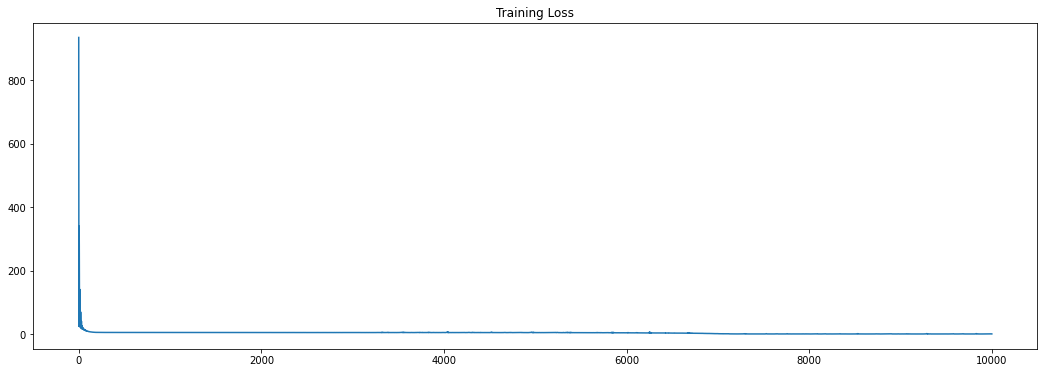

In [7]:
fig = plt.figure(figsize=(18,6))
plt.plot(training_loss) 
plt.title('Training Loss')

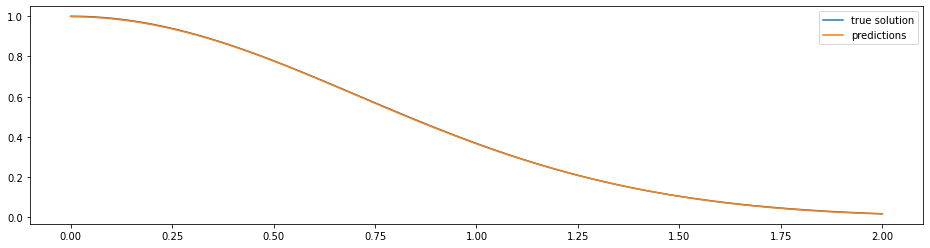

In [8]:
# test the model 
x_test = np.linspace(0,2,100).reshape(100,1)
x_test_tensor = tf.convert_to_tensor(x_test)

model.load_weights('best_model')
y_analytical = np.exp(-x_test**2)
y_pred = model(x_test_tensor)

fig = plt.figure(figsize=(16,4))
plt.plot(x_test, y_analytical, label='true solution')
plt.plot(x_test, y_pred, label='predictions')
plt.legend();